<a href="https://colab.research.google.com/github/SergeiVKalinin/MSE_Fall2024/blob/main/Module_9/28_SkipGram_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import urllib.request
from collections import Counter
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader

# Download the Text8 dataset if not already downloaded
url = 'http://mattmahoney.net/dc/text8.zip'
if not os.path.exists('text8.zip'):
    urllib.request.urlretrieve(url, 'text8.zip')

# Unzip the dataset
import zipfile
with zipfile.ZipFile('text8.zip', 'r') as zip_ref:
    zip_ref.extractall()

# Load the data
with open('text8', 'r') as f:
    text = f.read()

# Tokenize the text into words
words = text.split()
vocab_size = 10000  # Define vocabulary size

# Step 1: Building the vocabulary and encoding
word_counts = Counter(words)
most_common_words = [word for word, _ in word_counts.most_common(vocab_size)]
word_to_idx = {word: i for i, word in enumerate(most_common_words)}
idx_to_word = {i: word for word, i in word_to_idx.items()}

# Step 2: Filter the text
filtered_words = [word for word in words if word in word_to_idx]

In [2]:
len(filtered_words)

15268026

In [3]:
filtered_words = filtered_words[:10000]
len(filtered_words)

10000

In [4]:
filtered_words[:10]

['anarchism',
 'originated',
 'as',
 'a',
 'term',
 'of',
 'abuse',
 'first',
 'used',
 'against']

In [5]:
import random

# Generate (target, context) pairs
def generate_skipgram_pairs(words, window_size=2):
    pairs = []
    for i, target_word in enumerate(words):
        target_idx = word_to_idx[target_word]
        # Define context window
        context_start = max(0, i - window_size)
        context_end = min(len(words), i + window_size + 1)
        for j in range(context_start, context_end):
            if j != i:
                context_word = words[j]
                context_idx = word_to_idx[context_word]
                pairs.append((target_idx, context_idx))
    return pairs

pairs = generate_skipgram_pairs(filtered_words)
print(f"Number of pairs: {len(pairs)}")


Number of pairs: 39994


In [6]:
pairs[0]

(5233, 3080)

In [7]:
words

['anarchism',
 'originated',
 'as',
 'a',
 'term',
 'of',
 'abuse',
 'first',
 'used',
 'against',
 'early',
 'working',
 'class',
 'radicals',
 'including',
 'the',
 'diggers',
 'of',
 'the',
 'english',
 'revolution',
 'and',
 'the',
 'sans',
 'culottes',
 'of',
 'the',
 'french',
 'revolution',
 'whilst',
 'the',
 'term',
 'is',
 'still',
 'used',
 'in',
 'a',
 'pejorative',
 'way',
 'to',
 'describe',
 'any',
 'act',
 'that',
 'used',
 'violent',
 'means',
 'to',
 'destroy',
 'the',
 'organization',
 'of',
 'society',
 'it',
 'has',
 'also',
 'been',
 'taken',
 'up',
 'as',
 'a',
 'positive',
 'label',
 'by',
 'self',
 'defined',
 'anarchists',
 'the',
 'word',
 'anarchism',
 'is',
 'derived',
 'from',
 'the',
 'greek',
 'without',
 'archons',
 'ruler',
 'chief',
 'king',
 'anarchism',
 'as',
 'a',
 'political',
 'philosophy',
 'is',
 'the',
 'belief',
 'that',
 'rulers',
 'are',
 'unnecessary',
 'and',
 'should',
 'be',
 'abolished',
 'although',
 'there',
 'are',
 'differing',
 '

In [8]:
class SkipGramModel(nn.Module):
    def __init__(self, vocab_size, embed_dim):
        super(SkipGramModel, self).__init__()
        self.target_embedding = nn.Embedding(vocab_size, embed_dim)
        self.context_embedding = nn.Embedding(vocab_size, embed_dim)

    def forward(self, target_word, context_word):
        target_vec = self.target_embedding(target_word)
        context_vec = self.context_embedding(context_word)
        score = torch.mul(target_vec, context_vec).sum(dim=1)
        return score


In [9]:
class SkipGramDataset(Dataset):
    def __init__(self, pairs):
        self.pairs = pairs

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        target_word, context_word = self.pairs[idx]
        return torch.tensor(target_word, dtype=torch.long), torch.tensor(context_word, dtype=torch.long)

# Parameters
embed_dim = 100
batch_size = 64
learning_rate = 0.01
num_epochs = 5

# Create DataLoader
dataset = SkipGramDataset(pairs)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [10]:
# Instantiate the model, define loss and optimizer
model = SkipGramModel(vocab_size, embed_dim)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    total_loss = 0
    for target_word, context_word in dataloader:
        # Positive pairs
        labels = torch.ones(target_word.size(0))

        # Negative samples
        neg_context = torch.randint(0, vocab_size, context_word.size())
        neg_labels = torch.zeros(context_word.size(0))

        # Combine positive and negative pairs
        words = torch.cat((context_word, neg_context))
        targets = torch.cat((target_word, target_word))
        labels_combined = torch.cat((labels, neg_labels))

        # Forward pass
        scores = model(targets, words)
        loss = criterion(scores, labels_combined)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(dataloader)}')


Epoch 1/5, Loss: 3.141689634513855
Epoch 2/5, Loss: 1.6322745014190674
Epoch 3/5, Loss: 1.1603934839248657
Epoch 4/5, Loss: 0.8893322947502136
Epoch 5/5, Loss: 0.6788966186761856


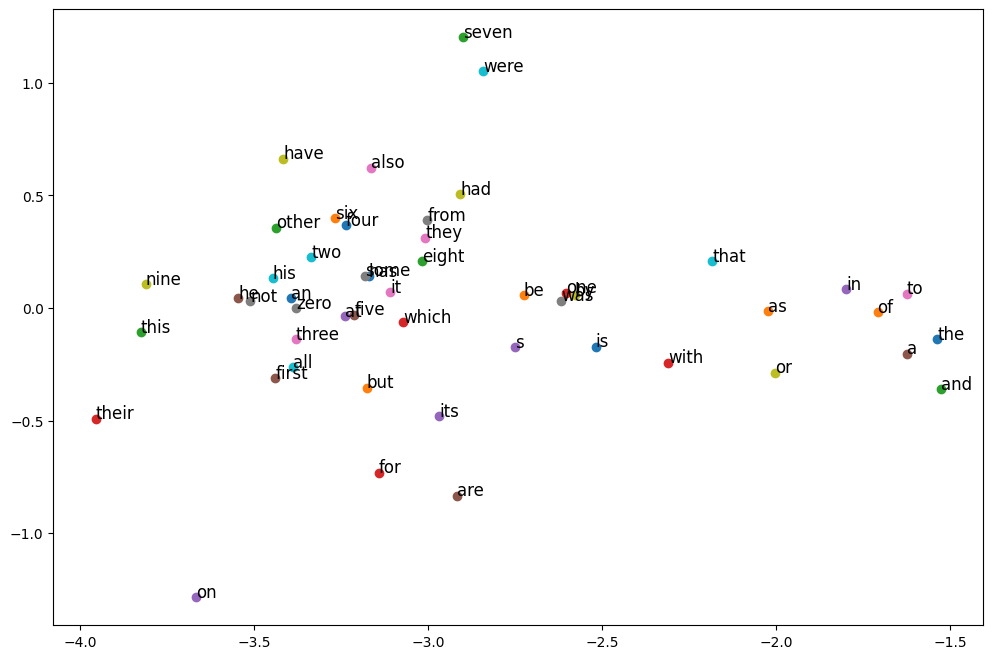

In [11]:
from sklearn.decomposition import PCA

# Extract the embeddings
embeddings = model.target_embedding.weight.data.numpy()
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings)

# Plot a few words in 2D space
import matplotlib.pyplot as plt

words_to_plot = 50
plt.figure(figsize=(12, 8))
for i in range(words_to_plot):
    plt.scatter(reduced_embeddings[i, 0], reduced_embeddings[i, 1])
    plt.text(reduced_embeddings[i, 0], reduced_embeddings[i, 1], idx_to_word[i], fontsize=12)
plt.show()


In [13]:
import nltk
from nltk.corpus import brown  # Using the Brown corpus as a sample larger dataset
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import OneHotEncoder
from collections import defaultdict

# Download the corpus
nltk.download('brown')
nltk.download('punkt')

# Load the Brown corpus
corpus = brown.sents(categories=['news'])
text = [word.lower() for sentence in corpus for word in sentence if word.isalpha()]

text = text[:10000]

# Parameters
window_size = 2
embedding_dim = 50
learning_rate = 0.001
epochs = 5

# Prepare vocabulary and word mappings
vocab = list(set(text))
word2idx = {word: idx for idx, word in enumerate(vocab)}
idx2word = {idx: word for word, idx in word2idx.items()}
vocab_size = len(vocab)

# Generate CBOW training data
def generate_cbows(text, window_size):
    data = []
    for i, word in enumerate(text):
        target = word2idx[word]
        context = []
        for j in range(-window_size, window_size + 1):
            if j != 0 and 0 <= i + j < len(text):
                context.append(word2idx[text[i + j]])
        if len(context) == 2 * window_size:
            data.append((context, target))
    return data

# Prepare data
cbow_data = generate_cbows(text, window_size)

# CBOW Model definition
class CBOW(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(CBOW, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear = nn.Linear(embedding_dim, vocab_size)

    def forward(self, context_idxs):
        embeds = self.embeddings(context_idxs).mean(dim=1)
        out = self.linear(embeds)
        return out

# Instantiate model, loss function, and optimizer
model = CBOW(vocab_size, embedding_dim)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(epochs):
    total_loss = 0
    for context, target in cbow_data:
        context_idxs = torch.tensor(context, dtype=torch.long)
        target = torch.tensor([target], dtype=torch.long)

        optimizer.zero_grad()
        log_probs = model(context_idxs.unsqueeze(0))
        loss = criterion(log_probs, target)

        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f'Epoch {epoch+1}/{epochs}, Loss: {total_loss:.4f}')

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Epoch 1/5, Loss: 72428.1870
Epoch 2/5, Loss: 60965.3467


KeyboardInterrupt: 

In [14]:
text

['the',
 'fulton',
 'county',
 'grand',
 'jury',
 'said',
 'friday',
 'an',
 'investigation',
 'of',
 'recent',
 'primary',
 'election',
 'produced',
 'no',
 'evidence',
 'that',
 'any',
 'irregularities',
 'took',
 'place',
 'the',
 'jury',
 'further',
 'said',
 'in',
 'presentments',
 'that',
 'the',
 'city',
 'executive',
 'committee',
 'which',
 'had',
 'charge',
 'of',
 'the',
 'election',
 'deserves',
 'the',
 'praise',
 'and',
 'thanks',
 'of',
 'the',
 'city',
 'of',
 'atlanta',
 'for',
 'the',
 'manner',
 'in',
 'which',
 'the',
 'election',
 'was',
 'conducted',
 'the',
 'term',
 'jury',
 'had',
 'been',
 'charged',
 'by',
 'fulton',
 'superior',
 'court',
 'judge',
 'durwood',
 'pye',
 'to',
 'investigate',
 'reports',
 'of',
 'possible',
 'irregularities',
 'in',
 'the',
 'primary',
 'which',
 'was',
 'won',
 'by',
 'ivan',
 'allen',
 'only',
 'a',
 'relative',
 'handful',
 'of',
 'such',
 'reports',
 'was',
 'received',
 'the',
 'jury',
 'said',
 'considering',
 'the',
 'w

In [15]:
# Display word embeddings
print("\nSample Word Embeddings:")
for word in ["make", "voted", "race", "text"]:
    word_embedding = model.embeddings(torch.tensor([word2idx[word]], dtype=torch.long)).detach().numpy()
    print(f"{word}: {word_embedding}")


Sample Word Embeddings:
make: [[ 1.2842433   2.6621816   0.45083773 -0.44746548  0.5927557  -0.81195915
  -1.9596845  -0.48749045  0.4736869  -0.41515324 -0.5533031  -0.09722394
   1.8832834  -1.6562016  -0.8035624  -1.1283143   1.3025934   1.0685962
  -0.88577247 -2.2061331   0.22337244 -1.741228   -0.30355197 -1.238534
  -0.38289922  1.591994   -1.174452    1.5492238  -1.6754308  -1.319768
   1.2887219   1.9849741  -0.13498242 -1.6372732  -1.6089468  -0.48572028
   1.5227101  -1.1890076   0.5042238  -0.64327896  0.788783    0.82359576
  -1.0232844   1.0264337  -1.654365   -0.45593935 -0.5990546   1.2264004
   1.7736906   0.17855227]]
voted: [[ 1.6717051   0.24619277 -0.00400922 -0.0578922   0.09003067  0.5949691
   0.15803087  0.17490628  1.403263    0.14366099  0.17624645 -0.04134371
   0.53168184  0.91546965 -1.6999456  -0.43935376  0.13281272  0.05272733
  -0.02752543 -1.2368027   0.78370744  1.558061    0.8107177   0.4580544
   1.5122954  -1.6139088  -2.119505    0.38785845  0.4

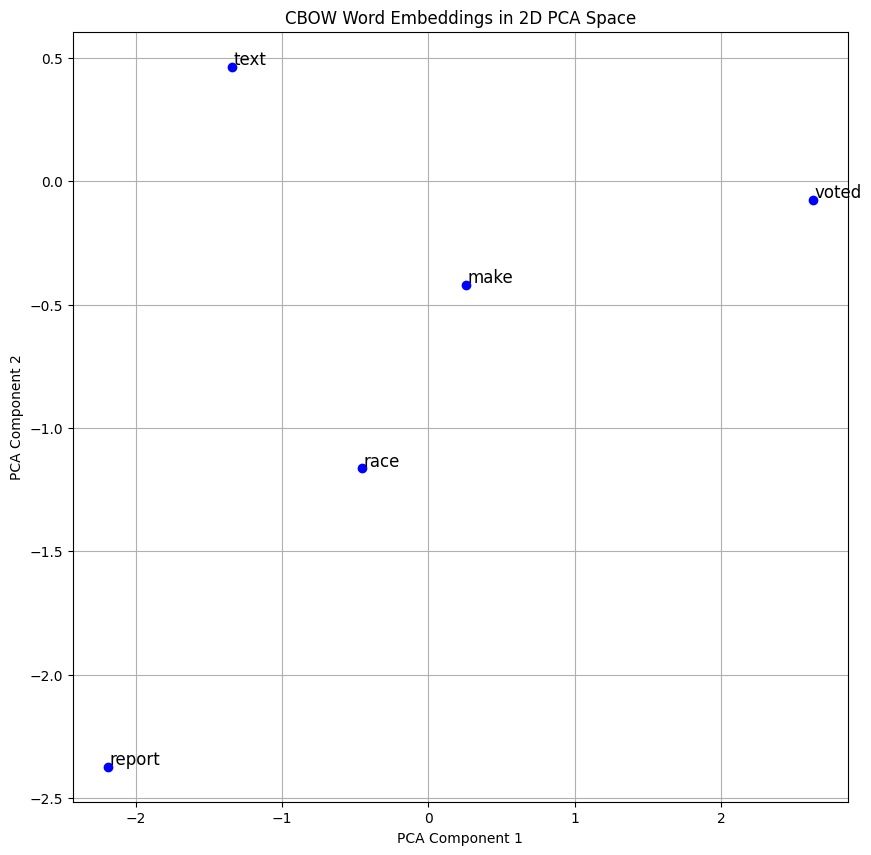

In [17]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Word Embeddings after Training
word_embeddings = model.embeddings.weight.data.numpy()

# Apply PCA for dimensionality reduction to 2D
pca = PCA(n_components=2)
word_embeddings_2d = pca.fit_transform(word_embeddings)

# Select a subset of words to visualize (for readability)
words_to_plot = ["make", "voted", "race", "text", "report"]
indices_to_plot = [word2idx[word] for word in words_to_plot]

# Plotting the Embeddings in 2D
plt.figure(figsize=(10, 10))
for i, index in enumerate(indices_to_plot):
    x, y = word_embeddings_2d[index]
    plt.scatter(x, y, marker='o', color='blue')
    plt.text(x + 0.01, y + 0.01, words_to_plot[i], fontsize=12)

plt.title("CBOW Word Embeddings in 2D PCA Space")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.grid(True)
plt.show()